### Primer paso

In [1]:
import pandas as pd
import numpy as np
df_diabetes = pd.read_csv('db_cardiabetes.csv')
df_diabetes.describe

<bound method NDFrame.describe of        Año_Registro  Edad        IMC  Diabetes  Colesterol_Total  \
0              2016  53.0  30.464413         0        203.053597   
1              2013  66.0  21.307639         0        214.198250   
2              2017  68.0  32.672495         0        178.338545   
3              2014  60.0  41.167111         0        208.059981   
4              2016  61.0  31.813888         1        260.781259   
...             ...   ...        ...       ...               ...   
15944          2017  40.0  27.900000         1        210.750000   
15945          2012  38.0  33.000000         1        226.150000   
15946          2012  46.0  25.900000         1        215.130000   
15947          2016  63.0  21.400000         1        228.540000   
15948          2017  33.0  23.200000         0        208.130000   

       Trigliceridos    PAS   PAD   Cohorte     HbA1c    Insulina         LDL  \
0         228.381680  146.4  89.7    cardio  5.483777   10.602855  1


Asegúrate de que 'database_imputada.csv' está en la misma carpeta.
Se ha generado la columna 'ID_Paciente' ya que no se encontró en el CSV original.
Advertencia: La columna categórica 'Consumo_Alcohol' no se encontró en el archivo CSV y será ignorada.
Advertencia: La columna categórica 'source_Diabetes' no se encontró en el archivo CSV y será ignorada.

--- Entrenando Autoencoder ---
Pérdida final del Autoencoder (entrenamiento): 2.1988
Pérdida final del Autoencoder (validación): 2.4879


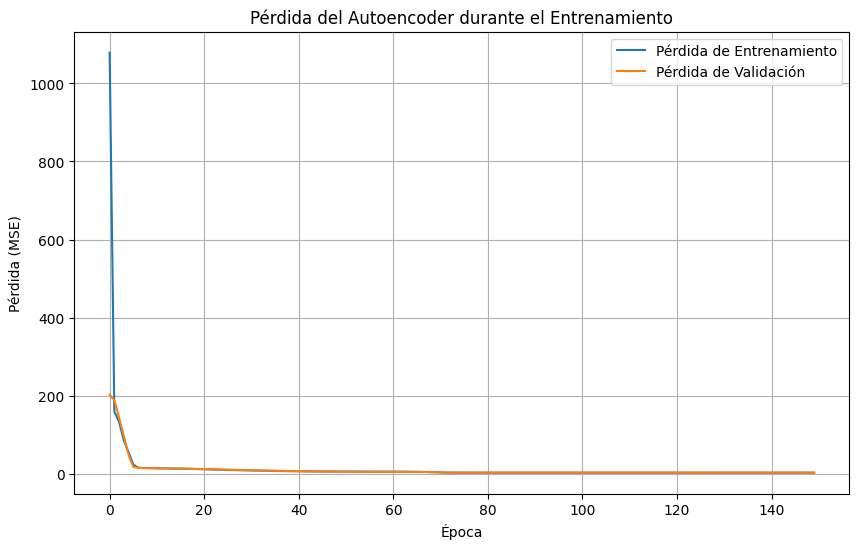

499/499 [==============================] - 1s 2ms/step


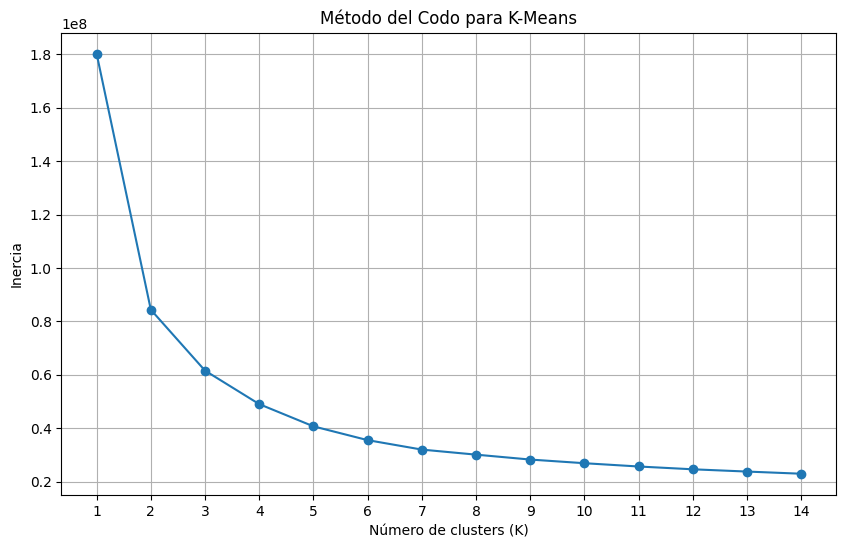


--- Estadísticas por perfil (valores promedio - RE-ESCALADOS PARA VISUALIZACIÓN) ---
| Perfil   | Edad   | IMC   | HbA1c   | PAS    | PAD   | Colesterol_Total   | LDL    | HDL   | Insulina   | Trigliceridos   |
|:---------|:-------|:------|:--------|:-------|:------|:-------------------|:-------|:------|:-----------|:----------------|
| 0        | 18     | 15    | 5.49    | 80     | 50    | 100                | 50     | 100   | 2          | 30              |
| 1        | 42.54  | 44.04 | 15      | 147.02 | 89.68 | 274.42             | 250    | 20    | 247.95     | 233.25          |
| 2        | 90     | 50    | 9       | 200    | 120   | 300                | 244.06 | 24.2  | 300        | 1000            |
| 3        | 77.59  | 35.57 | 4       | 165.08 | 99.89 | 123.43             | 123.27 | 73.59 | 84.4       | 790.22          |

--- Informe Personalizado de Salud y Nutrición para Paciente P0000 ---

## 1. Características del Paciente
---------------------------------
**Edad          

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from rdflib import Graph, Namespace, RDF, RDFS, Literal
import re

import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suprime warnings de TensorFlow (info y warnings)
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # Solo muestra errores de TensorFlow
warnings.filterwarnings('ignore') # Ignora warnings generales

# Cargar datos
try:
    df_diabetes = pd.read_csv('db_cardiabetes_desnorm.csv') 
except FileNotFoundError:
    print("Asegúrate de que 'database_imputada.csv' está en la misma carpeta.")
    exit()

# --- Asegurar que 'ID_Paciente' existe antes de CUALQUIER copia ---
if 'ID_Paciente' not in df_diabetes.columns:
    df_diabetes['ID_Paciente'] = [f'P{i:04d}' for i in range(len(df_diabetes))]
    print("Se ha generado la columna 'ID_Paciente' ya que no se encontró en el CSV original.")

# 1. Crear una copia del DataFrame para la visualización.
df_diabetes_original_for_display = df_diabetes.copy()

# 2. Crear un DataFrame NUEVO para el preprocesamiento específico del Autoencoder.
df_autoencoder_processed = df_diabetes.copy()

# --- Definición de Variables ---
variables_numericas = ['Edad', 'IMC', 'HbA1c', 'PAS', 'PAD', 'Colesterol_Total', 'LDL', 'HDL', 'Insulina', 'Trigliceridos']
variables_categoricas = ['Sexo', 'Consumo_Alcohol', 'Actividad_Fisica', 'Nivel_Estres', 'Riesgo_Cardiovascular', 'source_Diabetes', 'Tipo_Diabetes', 'Año_Registro']

# --- RANGOS REALISTAS PARA LA VISUALIZACIÓN ---
realistic_ranges = {
    'Edad': {'min': 18, 'max': 90},
    'IMC': {'min': 15.0, 'max': 50.0},
    'HbA1c': {'min': 4.0, 'max': 15.0},
    'PAS': {'min': 80, 'max': 200},
    'PAD': {'min': 50, 'max': 120},
    'Colesterol_Total': {'min': 100.0, 'max': 300.0},
    'LDL': {'min': 50, 'max': 250},
    'HDL': {'min': 20, 'max': 100},
    'Insulina': {'min': 2.0, 'max': 300.0},
    'Trigliceridos': {'min': 30.0, 'max': 1000.0}
}

# --- FUNCIÓN DE RE-ESCALADO A RANGO REALISTA ---
def rescale_to_realistic_range(df_input, columns_to_rescale, ranges):
    df_rescaled = df_input.copy()
    for col in columns_to_rescale:
        if col in df_rescaled.columns and col in ranges:
            current_min = df_rescaled[col].min()
            current_max = df_rescaled[col].max()
            
            if current_max == current_min:
                df_rescaled[col] = (ranges[col]['min'] + ranges[col]['max']) / 2
                continue

            df_rescaled[col] = (df_rescaled[col] - current_min) / (current_max - current_min)
            df_rescaled[col] = df_rescaled[col] * (ranges[col]['max'] - ranges[col]['min']) + ranges[col]['min']
            df_rescaled[col] = np.clip(df_rescaled[col], ranges[col]['min'], ranges[col]['max'])
    return df_rescaled

# --- Preparación de datos para el AUTOENCODER ---

# Imputar nulos
for col in variables_numericas:
    if col in df_autoencoder_processed.columns:
        df_autoencoder_processed[col] = pd.to_numeric(df_autoencoder_processed[col], errors='coerce')
        df_autoencoder_processed[col].fillna(df_autoencoder_processed[col].mean(), inplace=True)
    else:
        print(f"Advertencia: La columna numérica '{col}' no se encontró en el archivo CSV y será ignorada.")

for col in variables_categoricas:
    if col in df_autoencoder_processed.columns:
        if df_autoencoder_processed[col].dtype == 'int64' or df_autoencoder_processed[col].dtype == 'float64':
             df_autoencoder_processed[col] = df_autoencoder_processed[col].astype(str)
        if df_autoencoder_processed[col].isnull().any():
            df_autoencoder_processed[col].fillna(df_autoencoder_processed[col].mode()[0], inplace=True)
    else:
        print(f"Advertencia: La columna categórica '{col}' no se encontró en el archivo CSV y será ignorada.")

existing_numeric_cols = [col for col in variables_numericas if col in df_autoencoder_processed.columns]
existing_categorical_cols = [col for col in variables_categoricas if col in df_autoencoder_processed.columns]

X_numericas = df_autoencoder_processed[existing_numeric_cols].values

encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_categoricas_encoded = encoder.fit_transform(df_autoencoder_processed[existing_categorical_cols]).toarray()

X_for_autoencoder = np.concatenate([X_numericas, X_categoricas_encoded], axis=1)

# --- Autoencoder y K-Means ---
input_dim = X_for_autoencoder.shape[1]
encoding_dim = 8 # Puedes ajustar esto si la diversidad categórica sigue siendo un problema.
input_layer = Input(shape=(input_dim,))
encoded = Dense(input_dim // 2, activation='relu')(input_layer)
encoded = Dense(encoding_dim * 2, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
decoded = Dense(input_dim // 2, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)
autoencoder = Model(input_layer, decoded)

encoder_model = Model(input_layer, encoded)
decoder_input = Input(shape=(encoding_dim,))
decoder_output = Dense(encoding_dim * 2, activation='relu')(decoder_input)
decoder_output = Dense(input_dim // 2, activation='relu')(decoder_output)
decoder_output = Dense(input_dim, activation='linear')(decoder_output)
decoder_model = Model(decoder_input, decoder_output)

autoencoder.compile(optimizer='adam', loss='mse')

print("\n--- Entrenando Autoencoder ---")
history = autoencoder.fit(X_for_autoencoder, X_for_autoencoder, epochs=150, batch_size=64, validation_split=0.2, verbose=0)
print(f"Pérdida final del Autoencoder (entrenamiento): {history.history['loss'][-1]:.4f}")
print(f"Pérdida final del Autoencoder (validación): {history.history['val_loss'][-1]:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Autoencoder durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

X_encoded = encoder_model.predict(X_for_autoencoder)

inertia = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_encoded)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.xticks(K_range)
plt.grid(True)
plt.show()

k_optimo = 4
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)

df_autoencoder_processed['Perfil'] = kmeans.fit_predict(X_encoded)

df_diabetes_original_for_display['Perfil'] = df_autoencoder_processed['Perfil']

perfiles_stats_raw = df_diabetes_original_for_display.groupby('Perfil')[existing_numeric_cols].mean()
perfiles_stats_display = rescale_to_realistic_range(perfiles_stats_raw, existing_numeric_cols, realistic_ranges)

print("\n--- Estadísticas por perfil (valores promedio - RE-ESCALADOS PARA VISUALIZACIÓN) ---")
print(perfiles_stats_display.round(2).to_markdown(numalign="left", stralign="left"))


# --- Construcción de la Ontología ---
g = Graph()

FOOD = Namespace("http://example.org/food/")
NUT = Namespace("http://example.org/nutrient/")
COND = Namespace("http://example.org/condition/")
EX = Namespace("http://example.org/ex/")
PROF = Namespace("http://example.org/profile/")

g.bind("food", FOOD)
g.bind("nut", NUT)
g.bind("cond", COND)
g.bind("ex", EX)
g.bind("prof", PROF)

g.add((FOOD.Food, RDF.type, RDFS.Class))
g.add((NUT.Nutrient, RDF.type, RDFS.Class))
g.add((COND.Condition, RDF.type, RDFS.Class))
g.add((PROF.Profile, RDF.type, RDFS.Class))

g.add((EX.hasCondition, RDF.type, RDF.Property))
g.add((EX.beneficialFor, RDF.type, RDF.Property))
g.add((EX.harmfulFor, RDF.type, RDF.Property))
g.add((NUT.containsNutrient, RDF.type, RDF.Property))
g.add((PROF.hasNutritionalRecommendation, RDF.type, RDF.Property))

for profile_id in df_autoencoder_processed['Perfil'].unique():
    profile_uri = getattr(PROF, f"Profile_{profile_id}")
    g.add((profile_uri, RDF.type, PROF.Profile))

nutrient_benefits = {
    "Fiber": ["Diabetes", "HighCholesterol", "Overweight"],
    "Omega3": ["Hypertension", "HighCholesterol", "Diabetes"],
    "Calcium": ["Hypertension", "Underweight"],
    "Magnesium": ["Hypertension", "Diabetes"],
    "Protein": ["Underweight", "Diabetes", "Overweight"],
    "VitaminD": ["HighCholesterol", "Diabetes", "Underweight"],
    "Potassium": ["Hypertension"],
    "Antioxidants": ["Diabetes", "HighCholesterol"]
}

for nutrient, conditions in nutrient_benefits.items():
    g.add((getattr(NUT, nutrient), RDF.type, NUT.Nutrient))
    for condition_name in conditions:
        g.add((getattr(NUT, nutrient), EX.beneficialFor, getattr(COND, condition_name)))

nutrient_harms = {
    "Sodium": ["Hypertension"],
    "SaturatedFat": ["HighCholesterol", "Diabetes"],
    "SimpleSugars": ["Diabetes", "Overweight"]
}

for nutrient, conditions in nutrient_harms.items():
    g.add((getattr(NUT, nutrient), RDF.type, NUT.Nutrient))
    for condition_name in conditions:
        g.add((getattr(NUT, nutrient), EX.harmfulFor, getattr(COND, condition_name)))

food_nutrients = {
    "Salmon": ["Omega3", "Protein", "VitaminD"],
    "Walnuts": ["Omega3", "Magnesium", "Antioxidants", "Protein", "Fiber"],
    "Lentils": ["Fiber", "Protein", "Magnesium"],
    "Spinach": ["Magnesium", "Calcium", "Fiber", "Antioxidants"],
    "Yogurt": ["Calcium", "Protein"],
    "Oats": ["Fiber", "Magnesium", "Protein"],
    "Blueberries": ["Antioxidants", "Fiber"],
    "Almonds": ["Magnesium", "Protein", "Fiber", "Antioxidants"],
}

for food, nutrients in food_nutrients.items():
    g.add((getattr(FOOD, food), RDF.type, FOOD.Food))
    for nutrient in nutrients:
        g.add((getattr(FOOD, food), NUT.containsNutrient, getattr(NUT, nutrient)))

# --- FUNCIÓN MEJORADA: Obtener condiciones del paciente individual ---
def get_patient_conditions(patient_data_row):
    conditions = set()

    hba1c = patient_data_row.get('HbA1c', 0)
    pas = patient_data_row.get('PAS', 0)
    ldl = patient_data_row.get('LDL', 0)
    imc = patient_data_row.get('IMC', 0)
    pad = patient_data_row.get('PAD', 0)

    # Lógica de Diabetes más robusta:
    # Si la columna 'Diabetes' indica 1 (diagnóstico), O si HbA1c es alta.
    if patient_data_row.get('Diabetes') == 1 or hba1c > 6.5:
        conditions.add("Diabetes")
    # Puedes añadir un umbral para pre-diabetes si lo deseas, por ejemplo:
    # elif hba1c >= 5.7 and hba1c <= 6.4:
    #     conditions.add("Pre-Diabetes")

    # Consideramos PAS y PAD para hipertensión
    if pas > 130 or pad > 80:
        conditions.add("Hypertension")
    if ldl > 100:
        conditions.add("HighCholesterol")
    if imc > 25:
        conditions.add("Overweight")
    elif imc < 18.5:
        conditions.add("Underweight")
        
    return list(conditions)

# Función para obtener los nutrientes recomendados (sin cambios en la lógica)
def get_recommended_nutrients_for_patient(patient_conditions):
    nutrients_to_increase = set()
    nutrients_to_decrease = set()

    for condition_name in patient_conditions:
        condition_uri = getattr(COND, condition_name)
        
        beneficial_nuts = [subj for subj, pred, obj in g.triples((None, EX.beneficialFor, condition_uri))]
        nutrients_to_increase.update([str(n).split('/')[-1] for n in beneficial_nuts])

        harmful_nuts = [subj for subj, pred, obj in g.triples((None, EX.harmfulFor, condition_uri))]
        nutrients_to_decrease.update([str(n).split('/')[-1] for n in harmful_nuts])
        
    return sorted(list(nutrients_to_increase)), sorted(list(nutrients_to_decrease))

# --- Visualización de resultados ---

def display_patient_recommendations(patient_id):
    patient_data = df_diabetes_original_for_display[df_diabetes_original_for_display['ID_Paciente'] == patient_id]

    if patient_data.empty:
        print(f"No se encontraron datos para el paciente {patient_id}.")
        return

    patient_data_row = patient_data.iloc[0]

    print(f"\n--- Informe Personalizado de Salud y Nutrición para Paciente {patient_id} ---")

    ## 1. Características del Paciente
    print("\n## 1. Características del Paciente")
    print("---------------------------------")
    display_cols = ['Edad', 'Sexo', 'IMC', 'HbA1c', 'PAS', 'PAD', 'Colesterol_Total', 'LDL', 'HDL', 'Insulina', 'Trigliceridos', 
                    'Diabetes', 'Consumo_Alcohol', 'Actividad_Fisica', 'Nivel_Estres', 
                    'Riesgo_Cardiovascular', 'source_Diabetes', 'Tipo_Diabetes', 'Año_Registro', 'Perfil']
    existing_display_cols = [col for col in display_cols if col in patient_data.columns]
    
    patient_info_dict = {}
    for col in existing_display_cols:
        value = patient_data_row.get(col, "No disponible")
        
        if isinstance(value, (int, float)):
            if col == 'Diabetes':
                patient_info_dict[col] = "Sí" if int(value) == 1 else "No"
            elif col == 'Perfil':
                patient_info_dict[col] = str(int(value))
            elif col == 'source_Diabetes':
                patient_info_dict[col] = "Sí" if int(value) == 1 else "No"
            else:
                patient_info_dict[col] = f"{value:.2f}"
        elif pd.isna(value) or value == "No disponible":
            patient_info_dict[col] = "No disponible"
        else:
            patient_info_dict[col] = str(value)
            
    max_len_col = max(len(col) for col in patient_info_dict.keys()) if patient_info_dict else 0
    for col, val in patient_info_dict.items():
        print(f"**{col.ljust(max_len_col)}**: {val}")

    ## 2. Condiciones de Salud Detectadas
    detected_conditions = get_patient_conditions(patient_data_row)
    
    print("\n## 2. Condiciones de Salud Detectadas")
    print("-------------------------------------")
    if detected_conditions:
        for cond in sorted(list(set(detected_conditions))):
            print(f"- **{cond}**")
    else:
        print("Ninguna condición de salud específica detectada para este paciente basada en sus datos.")

    ## 3. Recomendaciones Nutricionales
    nutrients_to_increase, nutrients_to_decrease = get_recommended_nutrients_for_patient(detected_conditions)

    print("\n## 3. Recomendaciones Nutricionales")
    print("-----------------------------------")
    
    if nutrients_to_increase or nutrients_to_decrease:
        print("Basado en sus condiciones de salud, se recomienda prestar atención a los siguientes nutrientes:")
        
        if nutrients_to_increase:
            print("\n**Aumentar el consumo de:**")
            for nut in nutrients_to_increase:
                print(f"- **{nut}**")
        
        if nutrients_to_decrease:
            print("\n**Disminuir o limitar el consumo de:**")
            for nut in nutrients_to_decrease:
                print(f"- **{nut}**")
    else:
        print("No se identificaron nutrientes específicos para recomendar en base a las condiciones detectadas.")

    print("\n*Recuerde que estas son recomendaciones generales. Consulte a un profesional de la salud para un plan nutricional personalizado.*")


# Aplicar el re-escalado a los datos de display ANTES de generar el informe de un paciente específico
df_diabetes_original_for_display = rescale_to_realistic_range(df_diabetes_original_for_display, existing_numeric_cols, realistic_ranges)

# Ejemplo de uso de la función de visualización
patient_id_to_check = 'P0000' # Cambia este ID al paciente que quieras revisar
display_patient_recommendations(patient_id_to_check)


# --- Generando Pacientes Prototípicos por Perfil ---
print("\n" + "="*50)
print("--- Generando Pacientes Prototípicos por Perfil ---")
print("="*50)

cluster_centroids_encoded = kmeans.cluster_centers_

reconstructed_centroids_raw = decoder_model.predict(cluster_centroids_encoded)

num_numeric_features = len(existing_numeric_cols)

reconstructed_numeric_raw = pd.DataFrame(reconstructed_centroids_raw[:, :num_numeric_features], columns=existing_numeric_cols)
reconstructed_categorical_encoded = reconstructed_centroids_raw[:, num_numeric_features:]

prototypical_numeric_display = rescale_to_realistic_range(reconstructed_numeric_raw, existing_numeric_cols, realistic_ranges)

decoded_categorical_data = []
# --- LÓGICA DE DECODIFICACIÓN MEJORADA ---
for i, row_values in enumerate(reconstructed_categorical_encoded):
    decoded_row = {}
    start_idx = 0
    for original_col in existing_categorical_cols:
        categories_for_col = list(encoder.categories_[existing_categorical_cols.index(original_col)])
        
        num_one_hot_cols = len(categories_for_col) - (1 if 'drop' in encoder.get_params() and encoder.get_params()['drop'] == 'first' else 0)

        values_for_col = row_values[start_idx : start_idx + num_one_hot_cols]
        
        confidence_threshold = 0.3 # Ajusta este umbral. Un valor más bajo promueve más diversidad en las categorías.

        if 'drop' in encoder.get_params() and encoder.get_params()['drop'] == 'first':
            # Si hay al menos una categoría codificada con un valor significativo, la elegimos.
            if len(values_for_col) > 0 and np.max(values_for_col) > confidence_threshold:
                predicted_idx_in_encoded = np.argmax(values_for_col)
                # Sumamos 1 porque la primera categoría está "dropeada"
                decoded_row[original_col] = categories_for_col[predicted_idx_in_encoded + 1]
            else:
                # Si ninguna categoría codificada es lo suficientemente "confiante", elegimos la categoría base (la primera).
                decoded_row[original_col] = categories_for_col[0]
        else:
            # Si no hay drop, simplemente toma el valor más alto
            if len(values_for_col) > 0:
                predicted_idx = np.argmax(values_for_col)
                decoded_row[original_col] = categories_for_col[predicted_idx]
            else:
                decoded_row[original_col] = "No definida" 
            
        start_idx += num_one_hot_cols
    decoded_categorical_data.append(decoded_row)

reconstructed_categorical_descaled_df = pd.DataFrame(decoded_categorical_data)

prototypical_numeric_display.index = range(len(prototypical_numeric_display))
reconstructed_categorical_descaled_df.index = range(len(reconstructed_categorical_descaled_df))

prototypical_patients_df = pd.concat([prototypical_numeric_display, reconstructed_categorical_descaled_df], axis=1)

for i in range(k_optimo):
    print(f"\n--- Perfil {i} (Paciente Prototípico) ---")
    prototypical_patient_row = prototypical_patients_df.iloc[i]
    
    patient_info_dict = {}
    for col in prototypical_patient_row.index:
        value = prototypical_patient_row[col]
        if isinstance(value, (int, float)):
            patient_info_dict[col] = f"{value:.2f}"
        else:
            patient_info_dict[col] = str(value)
            
    max_len_col = max(len(col) for col in patient_info_dict.keys()) if patient_info_dict else 0
    for col, val in patient_info_dict.items():
        print(f"**{col.ljust(max_len_col)}**: {val}")

In [3]:
# --- Visualización de resultados ---

def display_patient_recommendations(patient_id):
    patient_data = df_diabetes_original_for_display[df_diabetes_original_for_display['ID_Paciente'] == patient_id]

    if patient_data.empty:
        print(f"No se encontraron datos para el paciente {patient_id}.")
        return

    patient_data_row = patient_data.iloc[0]

    print(f"\n--- Informe Personalizado de Salud y Nutrición para Paciente {patient_id} ---")

    ## 1. Características del Paciente
    print("\n## 1. Características del Paciente")
    print("---------------------------------")
    display_cols = ['Edad', 'Sexo', 'IMC', 'HbA1c', 'PAS', 'PAD', 'Colesterol_Total', 'LDL', 'HDL', 'Insulina', 'Trigliceridos', 
                    'Diabetes', 'Consumo_Alcohol', 'Actividad_Fisica', 'Nivel_Estres', 
                    'Riesgo_Cardiovascular', 'source_Diabetes', 'Tipo_Diabetes', 'Año_Registro', 'Perfil']
    existing_display_cols = [col for col in display_cols if col in patient_data.columns]
    
    patient_info_dict = {}
    for col in existing_display_cols:
        value = patient_data_row.get(col, "No disponible")
        
        if isinstance(value, (int, float)):
            if col == 'Diabetes':
                patient_info_dict[col] = "Sí" if int(value) == 1 else "No"
            elif col == 'Perfil':
                patient_info_dict[col] = str(int(value))
            elif col == 'source_Diabetes':
                patient_info_dict[col] = "Sí" if int(value) == 1 else "No"
            else:
                patient_info_dict[col] = f"{value:.2f}"
        elif pd.isna(value) or value == "No disponible":
            patient_info_dict[col] = "No disponible"
        else:
            patient_info_dict[col] = str(value)
            
    max_len_col = max(len(col) for col in patient_info_dict.keys()) if patient_info_dict else 0
    for col, val in patient_info_dict.items():
        print(f"**{col.ljust(max_len_col)}**: {val}")

    ## 2. Condiciones de Salud Detectadas
    detected_conditions = get_patient_conditions(patient_data_row)
    
    print("\n## 2. Condiciones de Salud Detectadas")
    print("-------------------------------------")
    if detected_conditions:
        for cond in sorted(list(set(detected_conditions))):
            print(f"- **{cond}**")
    else:
        print("Ninguna condición de salud específica detectada para este paciente basada en sus datos.")

    ## 3. Recomendaciones Nutricionales
    nutrients_to_increase, nutrients_to_decrease = get_recommended_nutrients_for_patient(detected_conditions)

    print("\n## 3. Recomendaciones Nutricionales")
    print("-----------------------------------")
    
    if nutrients_to_increase or nutrients_to_decrease:
        print("Basado en sus condiciones de salud, se recomienda prestar atención a los siguientes nutrientes:")
        
        if nutrients_to_increase:
            print("\n**Aumentar el consumo de:**")
            for nut in nutrients_to_increase:
                print(f"- **{nut}**")
        
        if nutrients_to_decrease:
            print("\n**Disminuir o limitar el consumo de:**")
            for nut in nutrients_to_decrease:
                print(f"- **{nut}**")
    else:
        print("No se identificaron nutrientes específicos para recomendar en base a las condiciones detectadas.")

    print("\n*Recuerde que estas son recomendaciones generales. Consulte a un profesional de la salud para un plan nutricional personalizado.*")


# Aplicar el re-escalado a los datos de display ANTES de generar el informe de un paciente específico
df_diabetes_original_for_display = rescale_to_realistic_range(df_diabetes_original_for_display, existing_numeric_cols, realistic_ranges)

# Ejemplo de uso de la función de visualización
patient_id_to_check = 'P0100' # Cambia este ID al paciente que quieras revisar
display_patient_recommendations(patient_id_to_check)



--- Informe Personalizado de Salud y Nutrición para Paciente P0100 ---

## 1. Características del Paciente
---------------------------------
**Edad                 **: 79.20
**Sexo                 **: Mujer
**IMC                  **: 35.66
**HbA1c                **: 8.59
**PAS                  **: 191.46
**PAD                  **: 106.37
**Colesterol_Total     **: 223.17
**LDL                  **: 167.62
**HDL                  **: 47.67
**Insulina             **: 156.26
**Trigliceridos        **: 850.07
**Diabetes             **: 1
**Actividad_Fisica     **: Sedentario
**Nivel_Estres         **: Alto
**Riesgo_Cardiovascular**: Riesgo Elevado
**Tipo_Diabetes        **: Tipo 2
**Año_Registro         **: 2011
**Perfil               **: 2

## 2. Condiciones de Salud Detectadas
-------------------------------------
- **Diabetes**
- **HighCholesterol**
- **Hypertension**
- **Overweight**

## 3. Recomendaciones Nutricionales
-----------------------------------
Basado en sus condiciones de sa

Lógica Propuesta para el Riesgo Cardiovascular
Para calcular el riesgo cardiovascular, consideraremos las siguientes variables clave y sus umbrales. Es importante destacar que estas son reglas heurísticas para el propósito de este proyecto y no reemplazan una evaluación clínica completa con herramientas estandarizadas (como las calculadoras de riesgo de Framingham o SCORE). Sin embargo, son un excelente punto de partida para tu sistema:

    -Edad: Mayor edad es un factor de riesgo.
    -Sexo: Históricamente, se ha considerado que los hombres tienen un riesgo ligeramente mayor a la misma edad, pero esto es cada vez más matizado.Por simplicidad, podemos usarlo si hay diferencias significativas en la base de datos o centrarlo en otros factores más directamente medibles.
    -IMC: Obesidad aumenta el riesgo.
    -HbA1c / Diabetes: La diabetes es un factor de riesgo mayor.
    -PAS/PAD (Presión Arterial): Hipertensión es un factor de riesgo.
    -Colesterol (LDL, HDL, Total): Dislipidemia es un factor de riesgo.
    -Triglicéridos: Niveles altos son un factor de riesgo.
    -Actividad Física: Sedentarismo aumenta el riesgo.
    -Nivel de Estrés: Estrés alto puede contribuir al riesgo.

### Ontologia Nutricional por Paciente

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from rdflib import Graph, Namespace, RDF, RDFS, Literal
import re

import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
tf.get_logger().setLevel('ERROR') 
warnings.filterwarnings('ignore') 

# Cargar datos
try:
    df_diabetes = pd.read_csv('db_cardiabetes.csv') 
except FileNotFoundError:
    print("Asegúrate de que 'db_cardiabetes.csv' está en la misma carpeta.")
    exit()

# --- Asegurar que 'ID_Paciente' existe ---
if 'ID_Paciente' not in df_diabetes.columns:
    df_diabetes['ID_Paciente'] = [f'P{i:04d}' for i in range(len(df_diabetes))]
    print("Se ha generado la columna 'ID_Paciente' ya que no se encontró en el CSV original.")

# 1. Crear una copia del DataFrame para la visualización.
df_diabetes_original_for_display = df_diabetes.copy()

# 2. Crear un DataFrame NUEVO para el preprocesamiento específico del Autoencoder.
df_autoencoder_processed = df_diabetes.copy()

# --- Definición de Variables ---
variables_numericas = ['Edad', 'IMC', 'HbA1c', 'PAS', 'PAD', 'Colesterol_Total', 'LDL', 'HDL', 'Insulina', 'Trigliceridos']
variables_categoricas = ['Sexo','Riesgo_Cardiovascular' ,'Actividad_Fisica', 'Nivel_Estres', 'Tipo_Diabetes']

# --- RANGOS REALISTAS PARA LA VISUALIZACIÓN ---
realistic_ranges = {
    'Edad': {'min': 18, 'max': 90},
    'IMC': {'min': 15.0, 'max': 50.0},
    'HbA1c': {'min': 4.0, 'max': 15.0},
    'PAS': {'min': 80, 'max': 200},
    'PAD': {'min': 50, 'max': 120},
    'Colesterol_Total': {'min': 100.0, 'max': 300.0},
    'LDL': {'min': 50, 'max': 250},
    'HDL': {'min': 20, 'max': 100},
    'Insulina': {'min': 2.0, 'max': 300.0},
    'Trigliceridos': {'min': 30.0, 'max': 1000.0}
}


Se ha generado la columna 'ID_Paciente' ya que no se encontró en el CSV original.


In [3]:
# --- FUNCIÓN DE RE-ESCALADO A RANGO REALISTA ---
def rescale_to_realistic_range(df_input, columns_to_rescale, ranges):
    df_rescaled = df_input.copy()
    for col in columns_to_rescale:
        if col in df_rescaled.columns and col in ranges:
            current_min = df_rescaled[col].min()
            current_max = df_rescaled[col].max()
            
            if current_max == current_min:
                df_rescaled[col] = (ranges[col]['min'] + ranges[col]['max']) / 2
                continue

            df_rescaled[col] = (df_rescaled[col] - current_min) / (current_max - current_min)
            df_rescaled[col] = df_rescaled[col] * (ranges[col]['max'] - ranges[col]['min']) + ranges[col]['min']
            df_rescaled[col] = np.clip(df_rescaled[col], ranges[col]['min'], ranges[col]['max'])
    return df_rescaled


--- Entrenando Autoencoder ---
Pérdida final del Autoencoder (entrenamiento): 3.1358
Pérdida final del Autoencoder (validación): 3.6252


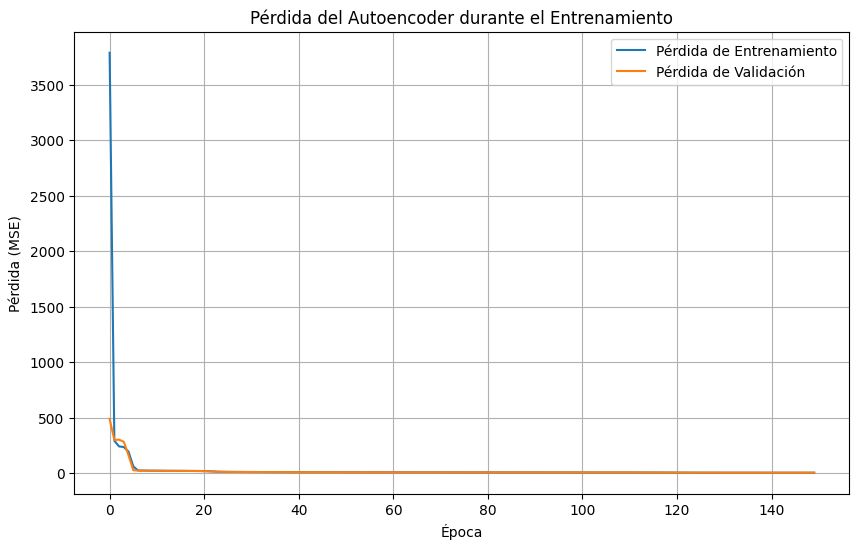

499/499 [==============================] - 1s 2ms/step


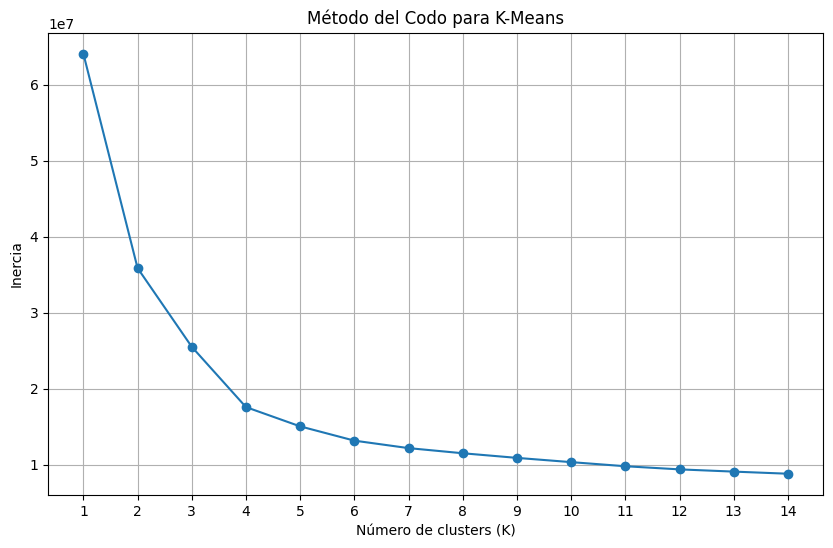


--- Estadísticas por perfil (valores promedio - RE-ESCALADOS PARA VISUALIZACIÓN) ---
| Perfil   | Edad   | IMC   | HbA1c   | PAS    | PAD   | Colesterol_Total   | LDL    | HDL   | Insulina   | Trigliceridos   |
|:---------|:-------|:------|:--------|:-------|:------|:-------------------|:-------|:------|:-----------|:----------------|
| 0        | 90     | 50    | 8.1     | 200    | 120   | 300                | 250    | 23.97 | 300        | 1000            |
| 1        | 18     | 15    | 6.63    | 80     | 50    | 115.78             | 50     | 100   | 2          | 30              |
| 2        | 77.94  | 34.46 | 4       | 164.42 | 99.31 | 100                | 93.02  | 80.55 | 49.16      | 760.57          |
| 3        | 44.28  | 45.27 | 15      | 149.55 | 91.3  | 290.3              | 248.98 | 20    | 276        | 277.6           |


In [4]:
# --- Preparación de datos para el AUTOENCODER ---

# Imputar nulos
for col in variables_numericas:
    if col in df_autoencoder_processed.columns:
        df_autoencoder_processed[col] = pd.to_numeric(df_autoencoder_processed[col], errors='coerce')
        df_autoencoder_processed[col].fillna(df_autoencoder_processed[col].mean(), inplace=True)
    else:
        print(f"Advertencia: La columna numérica '{col}' no se encontró en el archivo CSV y será ignorada.")

for col in variables_categoricas:
    if col in df_autoencoder_processed.columns:
        if df_autoencoder_processed[col].dtype == 'int64' or df_autoencoder_processed[col].dtype == 'float64':
             df_autoencoder_processed[col] = df_autoencoder_processed[col].astype(str)
        if df_autoencoder_processed[col].isnull().any():
            df_autoencoder_processed[col].fillna(df_autoencoder_processed[col].mode()[0], inplace=True)
    else:
        print(f"Advertencia: La columna categórica '{col}' no se encontró en el archivo CSV y será ignorada.")

existing_numeric_cols = [col for col in variables_numericas if col in df_autoencoder_processed.columns]
existing_categorical_cols = [col for col in variables_categoricas if col in df_autoencoder_processed.columns]

X_numericas = df_autoencoder_processed[existing_numeric_cols].values

encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_categoricas_encoded = encoder.fit_transform(df_autoencoder_processed[existing_categorical_cols]).toarray()

X_for_autoencoder = np.concatenate([X_numericas, X_categoricas_encoded], axis=1)

# --- Autoencoder y K-Means ---
input_dim = X_for_autoencoder.shape[1]

encoding_dim = 12 
input_layer = Input(shape=(input_dim,))
encoded = Dense(input_dim // 2, activation='relu')(input_layer)
encoded = Dense(encoding_dim * 2, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
decoded = Dense(input_dim // 2, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)
autoencoder = Model(input_layer, decoded)

encoder_model = Model(input_layer, encoded)
decoder_input = Input(shape=(encoding_dim,))
decoder_output = Dense(encoding_dim * 2, activation='relu')(decoder_input)
decoder_output = Dense(input_dim // 2, activation='relu')(decoder_output)
decoder_output = Dense(input_dim, activation='linear')(decoder_output)
decoder_model = Model(decoder_input, decoder_output)

autoencoder.compile(optimizer='adam', loss='mse')

print("\n--- Entrenando Autoencoder ---")
history = autoencoder.fit(X_for_autoencoder, X_for_autoencoder, epochs=150, batch_size=64, validation_split=0.2, verbose=0)
print(f"Pérdida final del Autoencoder (entrenamiento): {history.history['loss'][-1]:.4f}")
print(f"Pérdida final del Autoencoder (validación): {history.history['val_loss'][-1]:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Autoencoder durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

X_encoded = encoder_model.predict(X_for_autoencoder)

inertia = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_encoded)
    inertia.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means')
plt.xticks(K_range)
plt.grid(True)
plt.show()

k_optimo = 4
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)

df_autoencoder_processed['Perfil'] = kmeans.fit_predict(X_encoded)

df_diabetes_original_for_display['Perfil'] = df_autoencoder_processed['Perfil']

perfiles_stats_raw = df_diabetes_original_for_display.groupby('Perfil')[existing_numeric_cols].mean()
perfiles_stats_display = rescale_to_realistic_range(perfiles_stats_raw, existing_numeric_cols, realistic_ranges)

print("\n--- Estadísticas por perfil (valores promedio - RE-ESCALADOS PARA VISUALIZACIÓN) ---")
print(perfiles_stats_display.round(2).to_markdown(numalign="left", stralign="left"))

In [5]:
# --- Construcción de la Ontología ---
g = Graph()

FOOD = Namespace("http://example.org/food/")
NUT = Namespace("http://example.org/nutrient/")
COND = Namespace("http://example.org/condition/")
EX = Namespace("http://example.org/ex/")
PROF = Namespace("http://example.org/profile/")

g.bind("food", FOOD)
g.bind("nut", NUT)
g.bind("cond", COND)
g.bind("ex", EX)
g.bind("prof", PROF)

g.add((FOOD.Food, RDF.type, RDFS.Class))
g.add((NUT.Nutrient, RDF.type, RDFS.Class))
g.add((COND.Condition, RDF.type, RDFS.Class))
g.add((PROF.Profile, RDF.type, RDFS.Class))

g.add((EX.hasCondition, RDF.type, RDF.Property))
g.add((EX.beneficialFor, RDF.type, RDF.Property))
g.add((EX.harmfulFor, RDF.type, RDF.Property))
g.add((NUT.containsNutrient, RDF.type, RDF.Property))
g.add((PROF.hasNutritionalRecommendation, RDF.type, RDF.Property))

for profile_id in df_autoencoder_processed['Perfil'].unique():
    profile_uri = getattr(PROF, f"Profile_{profile_id}")
    g.add((profile_uri, RDF.type, PROF.Profile))

# --- ACTUALIZADAS: Añadir niveles de riesgo cardiovascular ---
# Se añaden las nuevas condiciones de riesgo cardiovascular
g.add((COND.CardiovascularRisk_Low, RDF.type, COND.Condition))
g.add((COND.CardiovascularRisk_Moderate, RDF.type, COND.Condition))
g.add((COND.CardiovascularRisk_High, RDF.type, COND.Condition))
g.add((COND.CardiovascularRisk_VeryHigh, RDF.type, COND.Condition))


nutrient_benefits = {
    "Fiber": ["Diabetes", "HighCholesterol", "Overweight", "CardiovascularRisk_High", "CardiovascularRisk_VeryHigh"], 
    "Omega3": ["Hypertension", "HighCholesterol", "Diabetes", "CardiovascularRisk_High", "CardiovascularRisk_VeryHigh"], 
    "Calcium": ["Hypertension", "Underweight"],
    "Magnesium": ["Hypertension", "Diabetes", "CardiovascularRisk_High", "CardiovascularRisk_VeryHigh"], 
    "Protein": ["Underweight", "Diabetes", "Overweight"],
    "VitaminD": ["HighCholesterol", "Diabetes", "Underweight", "CardiovascularRisk_High", "CardiovascularRisk_VeryHigh"], 
    "Potassium": ["Hypertension"],
    "Antioxidants": ["Diabetes", "HighCholesterol", "CardiovascularRisk_High", "CardiovascularRisk_VeryHigh"] 
}

for nutrient, conditions in nutrient_benefits.items():
    g.add((getattr(NUT, nutrient), RDF.type, NUT.Nutrient))
    for condition_name in conditions:
        g.add((getattr(NUT, nutrient), EX.beneficialFor, getattr(COND, condition_name)))

nutrient_harms = {
    "Sodium": ["Hypertension", "CardiovascularRisk_High", "CardiovascularRisk_VeryHigh"], 
    "SaturatedFat": ["HighCholesterol", "Diabetes", "CardiovascularRisk_High", "CardiovascularRisk_VeryHigh"], 
    "SimpleSugars": ["Diabetes", "Overweight", "CardiovascularRisk_High", "CardiovascularRisk_VeryHigh"] 
}

for nutrient, conditions in nutrient_harms.items():
    g.add((getattr(NUT, nutrient), RDF.type, NUT.Nutrient))
    for condition_name in conditions:
        g.add((getattr(NUT, nutrient), EX.harmfulFor, getattr(COND, condition_name)))

food_nutrients = {
    "Salmon": ["Omega3", "Protein", "VitaminD"],
    "Walnuts": ["Omega3", "Magnesium", "Antioxidants", "Protein", "Fiber"],
    "Lentils": ["Fiber", "Protein", "Magnesium"],
    "Spinach": ["Magnesium", "Calcium", "Fiber", "Antioxidants"],
    "Yogurt": ["Calcium", "Protein"],
    "Oats": ["Fiber", "Magnesium", "Protein"],
    "Blueberries": ["Antioxidants", "Fiber"],
    "Almonds": ["Magnesium", "Protein", "Fiber", "Antioxidants"],
}

for food, nutrients in food_nutrients.items():
    g.add((getattr(FOOD, food), RDF.type, FOOD.Food))
    for nutrient in nutrients:
        g.add((getattr(FOOD, food), NUT.containsNutrient, getattr(NUT, nutrient)))


In [6]:
# --- FUNCIÓN: Cálculo del Riesgo Cardiovascular por Niveles ---
def calculate_cardiovascular_risk(patient_data_row):
    risk_score = 0
    
    edad = patient_data_row.get('Edad', 0)
    imc = patient_data_row.get('IMC', 0)
    hba1c = patient_data_row.get('HbA1c', 0)
    pas = patient_data_row.get('PAS', 0)
    pad = patient_data_row.get('PAD', 0)
    ldl = patient_data_row.get('LDL', 0)
    hdl = patient_data_row.get('HDL', 0)
    trigliceridos = patient_data_row.get('Trigliceridos', 0)
    actividad_fisica = patient_data_row.get('Actividad_Fisica', 'No disponible')
    nivel_estres = patient_data_row.get('Nivel_Estres', 'No disponible')
    sexo = patient_data_row.get('Sexo', 'No disponible')
    
    # 1. Factores de Edad
    if edad >= 65:
        risk_score += 3
    elif edad >= 45:
        risk_score += 2
    elif edad >= 30:
        risk_score += 1
        
    # 2. Factores de IMC
    if imc >= 30: # Obesidad
        risk_score += 3
    elif imc >= 25: # Sobrepeso
        risk_score += 2
    
    # 3. Factores de Glucosa (HbA1c / Diabetes)
    if patient_data_row.get('Diabetes') == 1 or hba1c > 6.5: # Diabetes
        risk_score += 4
    elif hba1c >= 5.7: # Pre-diabetes
        risk_score += 2

    # 4. Factores de Presión Arterial
    if pas >= 140 or pad >= 90: # Hipertensión Grado 2 o más
        risk_score += 4
    elif pas >= 130 or pad >= 80: # Hipertensión Grado 1
        risk_score += 2
        
    # 5. Factores de Lípidos
    if ldl > 160: # LDL muy alto
        risk_score += 3
    elif ldl > 130: # LDL alto
        risk_score += 2
        
    if hdl < 40 and sexo == 'Hombre': # HDL bajo en hombres
        risk_score += 2
    elif hdl < 50 and sexo == 'Mujer': # HDL bajo en mujeres
        risk_score += 2
        
    if trigliceridos > 200: # Triglicéridos altos
        risk_score += 2
    elif trigliceridos > 150: # Triglicéridos borderline
        risk_score += 1

    # 6. Factores de Estilo de Vida
    if actividad_fisica == 'Sedentario':
        risk_score += 2
    if nivel_estres == 'Alto':
        risk_score += 1
        
    # --- Mapeo del Score a Niveles de Riesgo ---
    if risk_score >= 12:
        return "CardiovascularRisk_VeryHigh"
    elif risk_score >= 8:
        return "CardiovascularRisk_High"
    elif risk_score >= 4:
        return "CardiovascularRisk_Moderate"
    else:
        return "CardiovascularRisk_Low"

In [7]:
# --- FUNCIÓN MEJORADA: Obtener condiciones del paciente individual ---
def get_patient_conditions(patient_data_row):
    conditions = set()

    hba1c = patient_data_row.get('HbA1c', 0)
    pas = patient_data_row.get('PAS', 0)
    ldl = patient_data_row.get('LDL', 0)
    imc = patient_data_row.get('IMC', 0)
    pad = patient_data_row.get('PAD', 0)
    
    # Lógica de Diabetes
    if patient_data_row.get('Diabetes') == 1 or hba1c > 6.5:
        conditions.add("Diabetes")

    # Consideramos PAS y PAD para hipertensión
    if pas > 130 or pad > 80:
        conditions.add("Hypertension")
    if ldl > 100:
        conditions.add("HighCholesterol")
    if imc > 25:
        conditions.add("Overweight")
    elif imc < 18.5:
        conditions.add("Underweight")
    
    # *** CAMBIO PRINCIPAL AQUÍ: Calcular el riesgo cardiovascular dinámicamente ***
    calculated_cardio_risk_level = calculate_cardiovascular_risk(patient_data_row)
    conditions.add(calculated_cardio_risk_level)
        
    return list(conditions)

In [8]:
# Función para obtener los nutrientes recomendados 
def get_recommended_nutrients_for_patient(patient_conditions):
    nutrients_to_increase = set()
    nutrients_to_decrease = set()

    for condition_name in patient_conditions:
        # Asegurarse de que la condición existe como URI en la ontología
        if hasattr(COND, condition_name):
            condition_uri = getattr(COND, condition_name)
            
            beneficial_nuts = [subj for subj, pred, obj in g.triples((None, EX.beneficialFor, condition_uri))]
            nutrients_to_increase.update([str(n).split('/')[-1] for n in beneficial_nuts])

            harmful_nuts = [subj for subj, pred, obj in g.triples((None, EX.harmfulFor, condition_uri))]
            nutrients_to_decrease.update([str(n).split('/')[-1] for n in harmful_nuts])
        
    return sorted(list(nutrients_to_increase)), sorted(list(nutrients_to_decrease))

In [9]:
# --- Visualización de resultados ---

def display_patient_recommendations(patient_id):
    patient_data = df_diabetes_original_for_display[df_diabetes_original_for_display['ID_Paciente'] == patient_id]

    if patient_data.empty:
        print(f"No se encontraron datos para el paciente {patient_id}.")
        return

    patient_data_row = patient_data.iloc[0]

    print(f"\n--- Informe Personalizado de Salud y Nutrición para Paciente {patient_id} ---")

    ## 1. Características del Paciente
    print("\n## 1. Características del Paciente")
    print("---------------------------------")
    display_cols = ['Edad', 'Sexo', 'IMC', 'HbA1c', 'PAS', 'PAD', 'Colesterol_Total', 'LDL', 'HDL', 'Insulina', 'Trigliceridos', 
                    'Diabetes', 'Actividad_Fisica', 'Nivel_Estres','Riesgo_Cardiovascular', 
                     'source_Diabetes', 'Tipo_Diabetes', 'Perfil']
    existing_display_cols = [col for col in display_cols if col in patient_data.columns]
    
    patient_info_dict = {}
    for col in existing_display_cols:
        value = patient_data_row.get(col, "No disponible")
        
        if isinstance(value, (int, float)):
            if col == 'Diabetes':
                patient_info_dict[col] = "Sí" if int(value) == 1 else "No"
            elif col == 'Perfil':
                patient_info_dict[col] = str(int(value))
            elif col == 'source_Diabetes':
                patient_info_dict[col] = "Sí" if int(value) == 1 else "No"
            else:
                patient_info_dict[col] = f"{value:.2f}"
        elif pd.isna(value) or value == "No disponible":
            patient_info_dict[col] = "No disponible"
        else:
            patient_info_dict[col] = str(value)
            
    max_len_col = max(len(col) for col in patient_info_dict.keys()) if patient_info_dict else 0
    for col, val in patient_info_dict.items():
        print(f"**{col.ljust(max_len_col)}**: {val}")

    ## 2. Condiciones de Salud Detectadas
    detected_conditions = get_patient_conditions(patient_data_row)
    
    print("\n## 2. Condiciones de Salud Detectadas")
    print("-------------------------------------")
    if detected_conditions:
        for cond in sorted(list(set(detected_conditions))):
            # Formatear el nombre del riesgo cardiovascular para que se vea bien
            if cond.startswith("CardiovascularRisk_"):
                display_cond = "Riesgo Cardiovascular " + cond.replace("CardiovascularRisk_", "").replace("High", "Alto").replace("Low", "Bajo").replace("Moderate", "Moderado").replace("Very", "Muy ")
            else:
                display_cond = cond
            print(f"- **{display_cond}**")
    else:
        print("Ninguna condición de salud específica detectada para este paciente basada en sus datos.")

    ## 3. Recomendaciones Nutricionales
    nutrients_to_increase, nutrients_to_decrease = get_recommended_nutrients_for_patient(detected_conditions)

    print("\n## 3. Recomendaciones Nutricionales")
    print("-----------------------------------")
    
    if nutrients_to_increase or nutrients_to_decrease:
        print("Basado en sus condiciones de salud, se recomienda prestar atención a los siguientes nutrientes:")
        
        if nutrients_to_increase:
            print("\n**Aumentar el consumo de:**")
            for nut in nutrients_to_increase:
                print(f"- **{nut}**")
        
        if nutrients_to_decrease:
            print("\n**Disminuir o limitar el consumo de:**")
            for nut in nutrients_to_decrease:
                print(f"- **{nut}**")
    else:
        print("No se identificaron nutrientes específicos para recomendar en base a las condiciones detectadas.")

    print("\n*Recuerde que estas son recomendaciones generales. Consulte a un profesional de la salud para un plan nutricional personalizado.*")


# Aplicar el re-escalado a los datos de display ANTES de generar el informe de un paciente específico
df_diabetes_original_for_display = rescale_to_realistic_range(df_diabetes_original_for_display, existing_numeric_cols, realistic_ranges)

# Ejemplo de uso de la función de visualización
patient_id_to_check = 'P0752' # Cambia este ID al paciente que quieras revisar
display_patient_recommendations(patient_id_to_check)


--- Informe Personalizado de Salud y Nutrición para Paciente P0752 ---

## 1. Características del Paciente
---------------------------------
**Edad                 **: 67.20
**Sexo                 **: Hombre
**IMC                  **: 29.15
**HbA1c                **: 12.00
**PAS                  **: 148.28
**PAD                  **: 95.02
**Colesterol_Total     **: 165.62
**LDL                  **: 71.20
**HDL                  **: 68.36
**Insulina             **: 2.00
**Trigliceridos        **: 657.42
**Diabetes             **: 1
**Actividad_Fisica     **: Moderado
**Nivel_Estres         **: Moderado
**Riesgo_Cardiovascular**: Riesgo Elevado
**Tipo_Diabetes        **: Tipo 1
**Perfil               **: 2

## 2. Condiciones de Salud Detectadas
-------------------------------------
- **Riesgo Cardiovascular Muy Alto**
- **Diabetes**
- **Hypertension**
- **Overweight**

## 3. Recomendaciones Nutricionales
-----------------------------------
Basado en sus condiciones de salud, se recomiend

In [10]:
# --- Generando Pacientes Prototípicos por Perfil ---
print("\n" + "="*50)
print("--- Generando Pacientes Prototípicos por Perfil ---")
print("="*50)

cluster_centroids_encoded = kmeans.cluster_centers_

reconstructed_centroids_raw = decoder_model.predict(cluster_centroids_encoded)

num_numeric_features = len(existing_numeric_cols)

reconstructed_numeric_raw = pd.DataFrame(reconstructed_centroids_raw[:, :num_numeric_features], columns=existing_numeric_cols)
reconstructed_categorical_encoded = reconstructed_centroids_raw[:, num_numeric_features:]

prototypical_numeric_display = rescale_to_realistic_range(reconstructed_numeric_raw, existing_numeric_cols, realistic_ranges)

decoded_categorical_data = []

# --- LÓGICA DE DECODIFICACIÓN  ---
for i, row_values in enumerate(reconstructed_categorical_encoded):
    decoded_row = {}
    start_idx = 0
    for original_col in existing_categorical_cols:
        categories_for_col = list(encoder.categories_[existing_categorical_cols.index(original_col)])
        
        num_one_hot_cols = len(categories_for_col) - (1 if 'drop' in encoder.get_params() and encoder.get_params()['drop'] == 'first' else 0)

        values_for_col = row_values[start_idx : start_idx + num_one_hot_cols]
        
        confidence_threshold = 0.3 # Ajusta este umbral. Un valor más bajo promueve más diversidad en las categorías.

        if 'drop' in encoder.get_params() and encoder.get_params()['drop'] == 'first':
            # Si hay al menos una categoría codificada con un valor significativo, la elegimos.
            if len(values_for_col) > 0 and np.max(values_for_col) > confidence_threshold:
                predicted_idx_in_encoded = np.argmax(values_for_col)
                # Sumamos 1 porque la primera categoría está "dropeada"
                decoded_row[original_col] = categories_for_col[predicted_idx_in_encoded + 1]
            else:
                # Si ninguna categoría codificada es lo suficientemente "confiante", elegimos la categoría base (la primera).
                decoded_row[original_col] = categories_for_col[0]
        else:
            # Si no hay drop, simplemente toma el valor más alto
            if len(values_for_col) > 0:
                predicted_idx = np.argmax(values_for_col)
                decoded_row[original_col] = categories_for_col[predicted_idx]
            else:
                decoded_row[original_col] = "No definida" 
            
        start_idx += num_one_hot_cols
    decoded_categorical_data.append(decoded_row)

reconstructed_categorical_descaled_df = pd.DataFrame(decoded_categorical_data)

prototypical_numeric_display.index = range(len(prototypical_numeric_display))
reconstructed_categorical_descaled_df.index = range(len(reconstructed_categorical_descaled_df))

prototypical_patients_df = pd.concat([prototypical_numeric_display, reconstructed_categorical_descaled_df], axis=1)

for i in range(k_optimo):
    print(f"\n--- Perfil {i} (Paciente Prototípico) ---")
    prototypical_patient_row = prototypical_patients_df.iloc[i]
    
    patient_info_dict = {}
    for col in prototypical_patient_row.index:
        value = prototypical_patient_row[col]
        if isinstance(value, (int, float)):
            patient_info_dict[col] = f"{value:.2f}"
        else:
            patient_info_dict[col] = str(value)
            
    max_len_col = max(len(col) for col in patient_info_dict.keys()) if patient_info_dict else 0
    for col, val in patient_info_dict.items():
        print(f"**{col.ljust(max_len_col)}**: {val}")


--- Generando Pacientes Prototípicos por Perfil ---
1/1 [==============================] - 0s 86ms/step

--- Perfil 0 (Paciente Prototípico) ---
**Edad                 **: 90.0
**IMC                  **: 30.235458
**HbA1c                **: 4.0
**PAS                  **: 200.0
**PAD                  **: 108.27858
**Colesterol_Total     **: 300.0
**LDL                  **: 250.0
**HDL                  **: 100.0
**Insulina             **: 134.59825
**Trigliceridos        **: 517.0204
**Sexo                 **: Mujer
**Riesgo_Cardiovascular**: Riesgo Elevado
**Actividad_Fisica     **: Sedentario
**Nivel_Estres         **: Bajo
**Tipo_Diabetes        **: Tipo 1

--- Perfil 1 (Paciente Prototípico) ---
**Edad                 **: 18.0
**IMC                  **: 37.433937
**HbA1c                **: 15.0
**PAS                  **: 80.0
**PAD                  **: 61.351593
**Colesterol_Total     **: 100.0
**LDL                  **: 188.96527
**HDL                  **: 43.95199
**Insulina      